# Importing and loading data

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/Colab_Notebooks')

Drive already mounted at /content/Colab_Notebooks; to attempt to forcibly remount, call drive.mount("/content/Colab_Notebooks", force_remount=True).


In [ ]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, auc, roc_curve
from sklearn.base import clone
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import chi2, SelectKBest
%matplotlib inline

SEED = 42

warnings.filterwarnings('ignore') # for ignoring any warnings

In [ ]:
uploaded = files.upload()

Saving train.csv to train (1).csv


In [ ]:
df = pd.read_csv('train.csv')

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

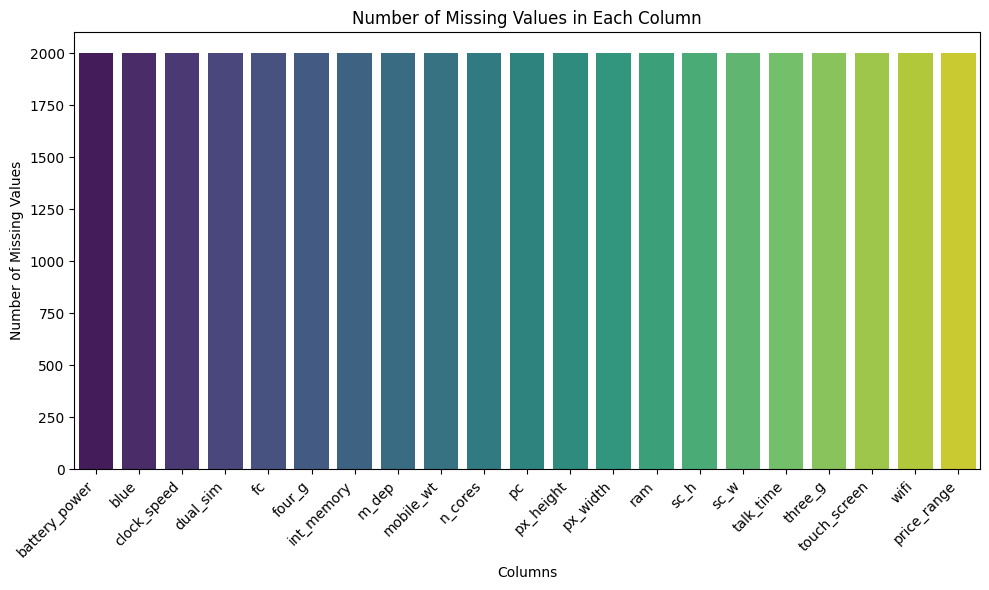

In [ ]:
missing_values = df.isnull().sum()

# Create a bar plot
plt.figure(figsize = (10, 6))
sns.barplot(x = missing_values.index, y=df.shape[0] - missing_values.values, palette = "viridis")
plt.title("Number of Missing Values in Each Column")
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation = 45, ha = "right")
plt.tight_layout()

plt.show()

**First, we have no missing data, this is simplifies the task. Second, we have quite a few functions, not that most of them have any real effect on the target variable. Thirdly, all data is in numerical format, i.e. vectorization and further work with the text is not required**

In [ ]:
df.describe(include='all')

battery_power       blue  clock_speed     dual_sim           fc  \
count    2000.000000  2000.0000  2000.000000  2000.000000  2000.000000   
mean     1238.518500     0.4950     1.522250     0.509500     4.309500   
std       439.418206     0.5001     0.816004     0.500035     4.341444   
min       501.000000     0.0000     0.500000     0.000000     0.000000   
25%       851.750000     0.0000     0.700000     0.000000     1.000000   
50%      1226.000000     0.0000     1.500000     1.000000     3.000000   
75%      1615.250000     1.0000     2.200000     1.000000     7.000000   
max      1998.000000     1.0000     3.000000     1.000000    19.000000   

            four_g   int_memory        m_dep    mobile_wt      n_cores  ...  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000  ...   
mean      0.521500    32.046500     0.501750   140.249000     4.520500  ...   
std       0.499662    18.145715     0.288416    35.399655     2.287837  ...   
min       0.000000     2.000000     0.100000    80.000000     1.000000  ...   
25%       0.000000    16.000000     0.200000   109.000000     3.000000  ...   
50%       1.000000    32.000000     0.500000   141.000000     4.000000  ...   
75%       1.000000    48.000000     0.800000   170.000000     7.000000  ...   
max       1.000000    64.000000     1.000000   200.000000     8.000000  ...   

         px_height     px_width          ram         sc_h         sc_w  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean    645.108000  1251.515500  2124.213000    12.306500     5.767000   
std     443.780811   432.199447  1084.732044     4.213245     4.356398   
min       0.000000   500.000000   256.000000     5.000000     0.000000   
25%     282.750000   874.750000  1207.500000     9.000000     2.000000   
50%     564.000000  1247.000000  2146.500000    12.000000     5.000000   
75%     947.250000  1633.000000  3064.500000    16.000000     9.000000   
max    1960.000000  1998.000000  3998.000000    19.000000    18.000000   

         talk_time      three_g  touch_screen         wifi  price_range  
count  2000.000000  2000.000000   2000.000000  2000.000000  2000.000000  
mean     11.011000     0.761500      0.503000     0.507000     1.500000  
std       5.463955     0.426273      0.500116     0.500076     1.118314  
min       2.000000     0.000000      0.000000     0.000000     0.000000  
25%       6.000000     1.000000      0.000000     0.000000     0.750000  
50%      11.000000     1.000000      1.000000     1.000000     1.500000  
75%      16.000000     1.000000      1.000000     1.000000     2.250000  
max      20.000000     1.000000      1.000000     1.000000     3.000000  

[8 rows x 21 columns]

In [ ]:
df.nunique()

battery_power    1094
blue                2
clock_speed        26
dual_sim            2
fc                 20
four_g              2
int_memory         63
m_dep              10
mobile_wt         121
n_cores             8
pc                 21
px_height        1137
px_width         1109
ram              1562
sc_h               15
sc_w               19
talk_time          19
three_g             2
touch_screen        2
wifi                2
price_range         4
dtype: int64

Based on the data above, we can conclude that the 'blue', 'dual_sim', 'four_g', 'n_cores', 'three_g', 'touch_screen', 'wifi', 'price_range' are categorical

In [ ]:
categorical_columns = ['blue', 'dual_sim', 'four_g', 'n_cores', 'three_g', 'touch_screen', 'wifi', 'price_range']
cat_data = df[categorical_columns].astype('str')

In [ ]:
num_data = df.drop(cat_data.columns, axis=1)
num_data.describe().T.round(2)

count     mean      std    min      25%     50%      75%  \
battery_power  2000.0  1238.52   439.42  501.0   851.75  1226.0  1615.25   
clock_speed    2000.0     1.52     0.82    0.5     0.70     1.5     2.20   
fc             2000.0     4.31     4.34    0.0     1.00     3.0     7.00   
int_memory     2000.0    32.05    18.15    2.0    16.00    32.0    48.00   
m_dep          2000.0     0.50     0.29    0.1     0.20     0.5     0.80   
mobile_wt      2000.0   140.25    35.40   80.0   109.00   141.0   170.00   
pc             2000.0     9.92     6.06    0.0     5.00    10.0    15.00   
px_height      2000.0   645.11   443.78    0.0   282.75   564.0   947.25   
px_width       2000.0  1251.52   432.20  500.0   874.75  1247.0  1633.00   
ram            2000.0  2124.21  1084.73  256.0  1207.50  2146.5  3064.50   
sc_h           2000.0    12.31     4.21    5.0     9.00    12.0    16.00   
sc_w           2000.0     5.77     4.36    0.0     2.00     5.0     9.00   
talk_time      2000.0    11.01     5.46    2.0     6.00    11.0    16.00   

                  max  
battery_power  1998.0  
clock_speed       3.0  
fc               19.0  
int_memory       64.0  
m_dep             1.0  
mobile_wt       200.0  
pc               20.0  
px_height      1960.0  
px_width       1998.0  
ram            3998.0  
sc_h             19.0  
sc_w             18.0  
talk_time        20.0

There are some numerical features in the dataset, such as m_dep, px_height, and sc_w that their min values don't make sense.

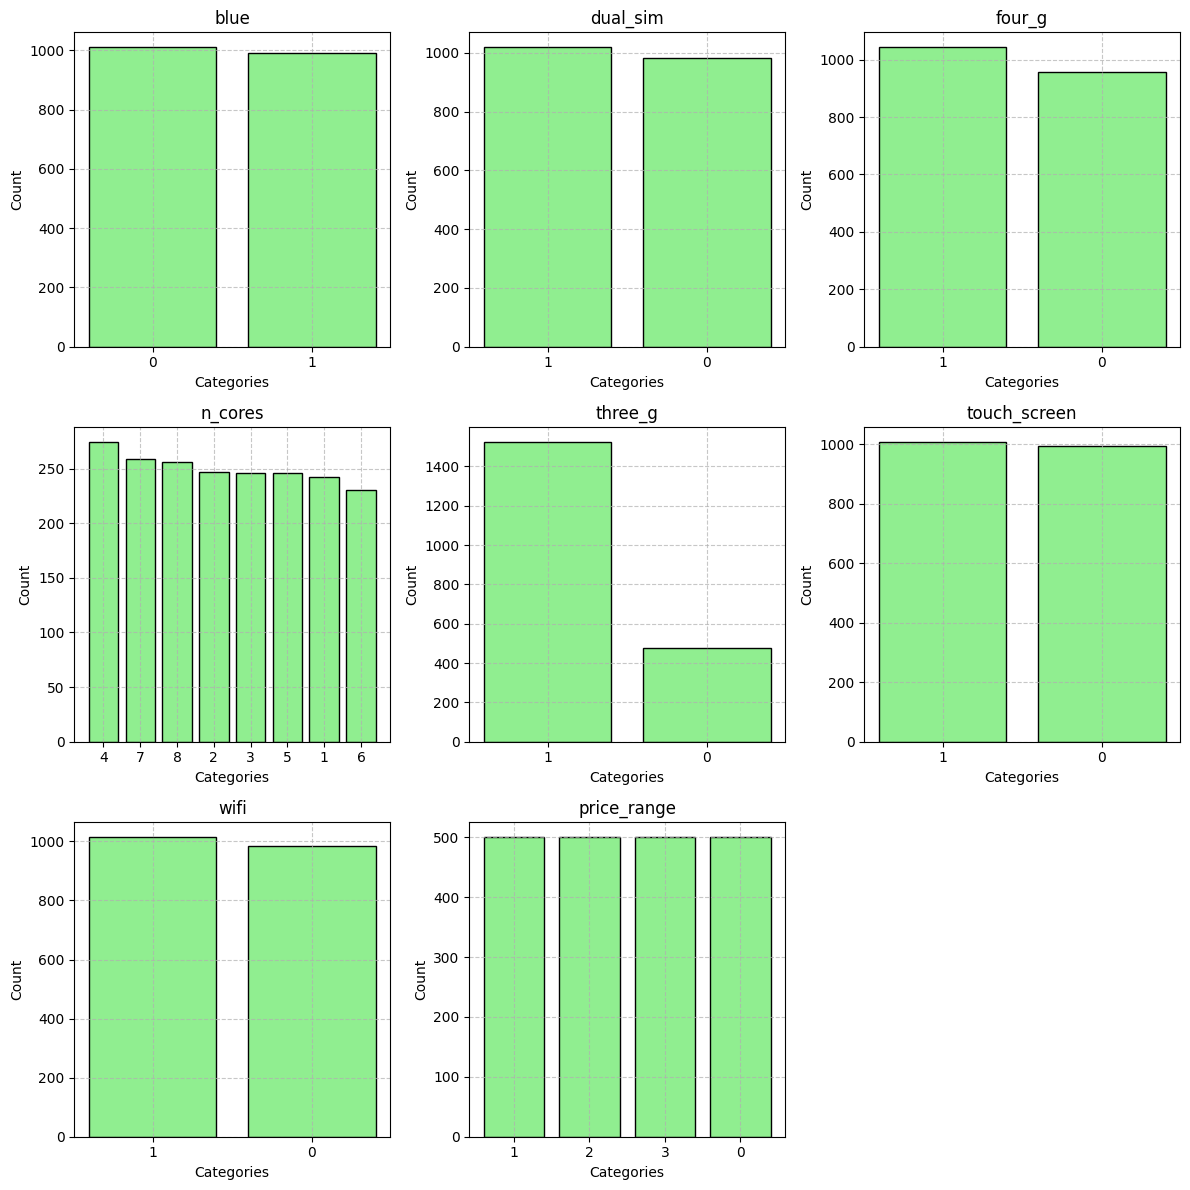

In [ ]:
fig, ax = plt.subplots(3, 3, figsize = (12, 12))

for i, column in enumerate(cat_data.columns):
    row = i // 3
    col = i % 3

    ax[row, col].bar(cat_data[column].value_counts().index, cat_data[column].value_counts(), color = 'lightgreen', edgecolor='black')

    ax[row, col].set_title(column)
    ax[row, col].set_xlabel('Categories')
    ax[row, col].set_ylabel('Count')
    ax[row, col].grid(True, linestyle = '--', alpha = 0.7)

ax[2, 2].axis('off')

plt.tight_layout()
plt.show()

We can see that in most cases the number of species for each category is balanced, although this has less effect than the balance factor of the target variable

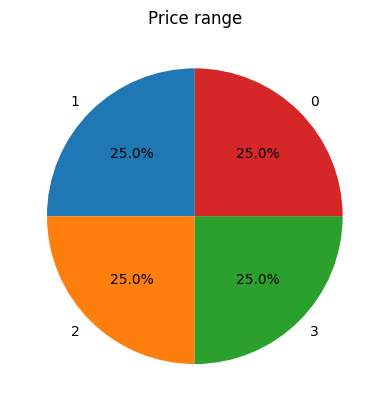

In [ ]:
plt.pie(cat_data['price_range'].value_counts(), labels = cat_data['price_range'].value_counts().index, autopct = '%1.1f%%', startangle = 90)
plt.title('Price range')
plt.show()

**The target variable - price range is balanced and the number of values in each category is the same - this means that we can consider that accuracy is an objective metric, although additional metrics will add better understanding**

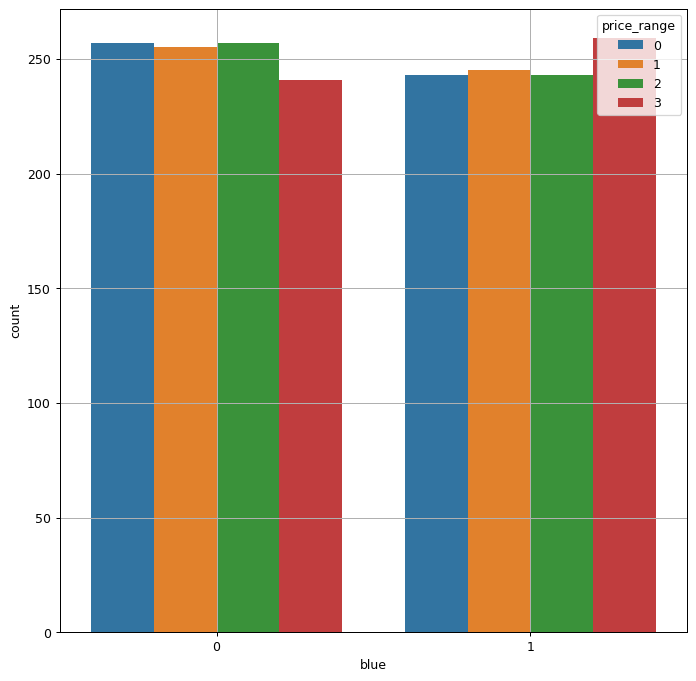

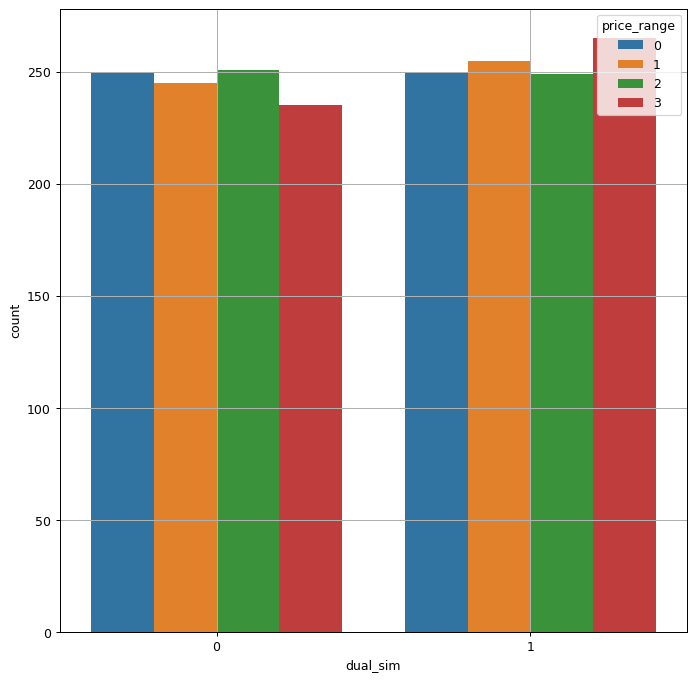

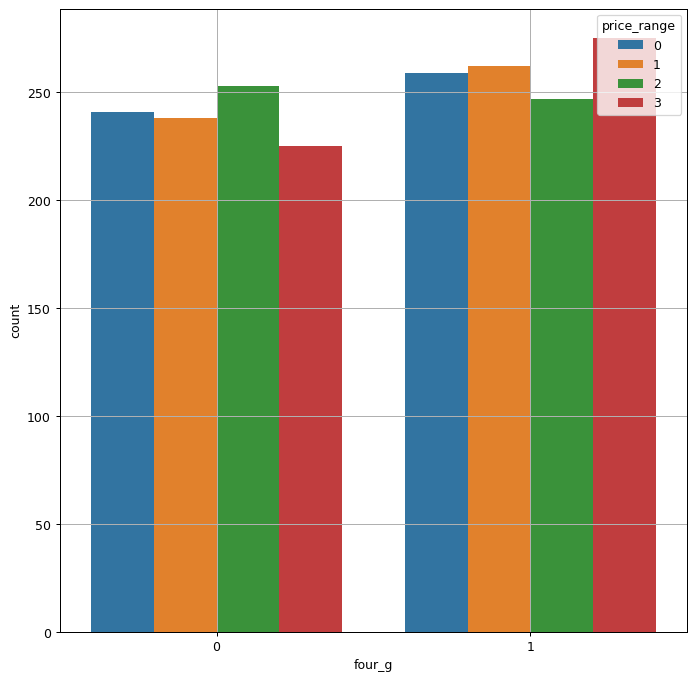

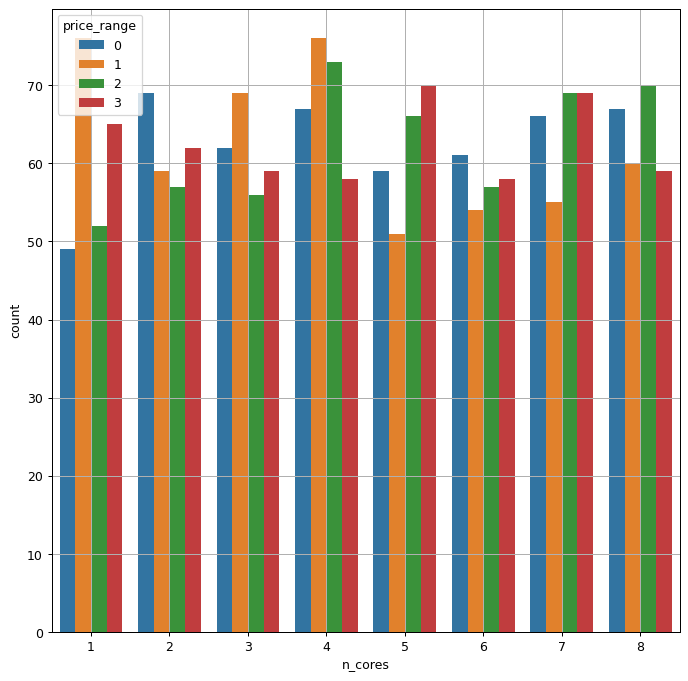

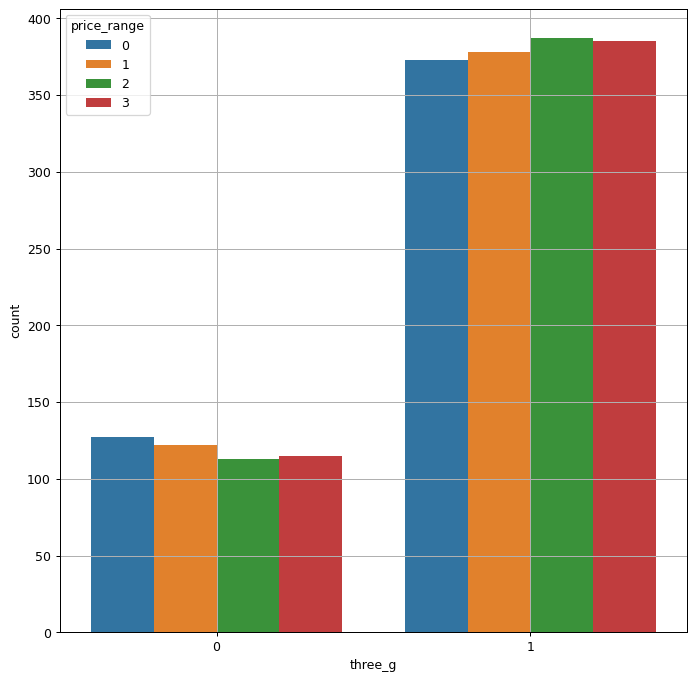

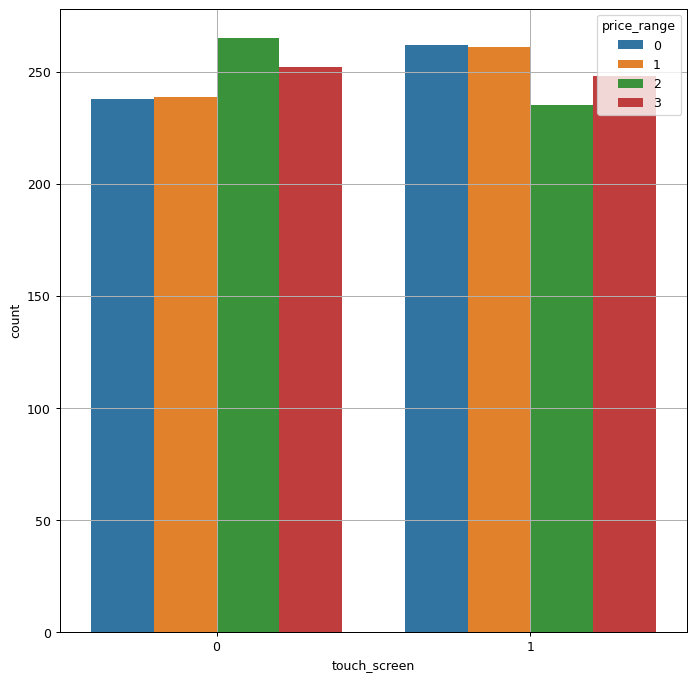

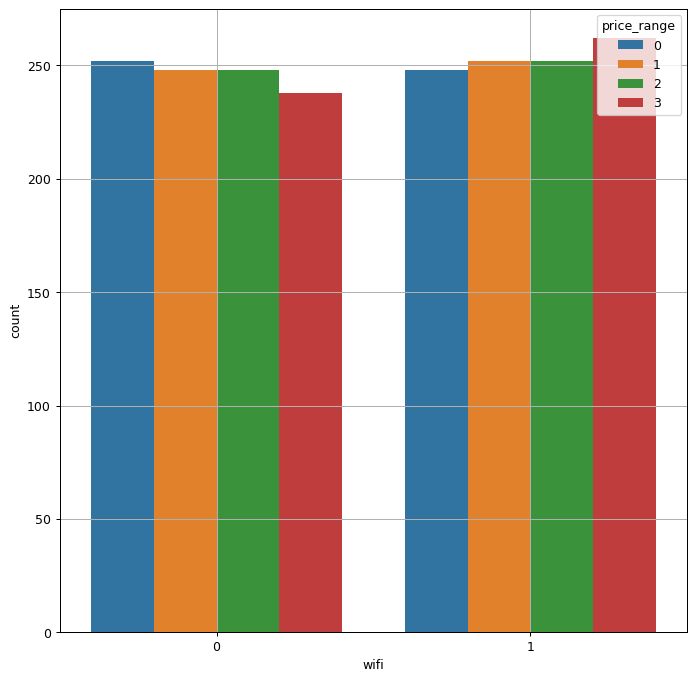

In [ ]:
names = ['blue', 'dual_sim', 'four_g', 'n_cores', 'three_g', 'touch_screen', 'wifi']

for col_name in names:
    plt.figure(figsize = (9, 9), dpi = 90)
    sns.countplot(x = col_name, data = df, hue = "price_range")
    plt.grid()

Categorical variables did not significantly affect the price variable, except for the number of cores

In [ ]:
fig, ax = plt.subplots(len(num_data.columns), 2, figsize = (24, 24), dpi = 400)

for i, col_name in enumerate(num_data.columns):
    sns.barplot(data = df, x = "price_range", y = col_name, ax = ax[i,0])

    sns.kdeplot(data = df[df["price_range"] == 0], x = col_name, fill = True, linewidth = 2, ax = ax[i,1], label = '0')
    sns.kdeplot(data = df[df["price_range"] == 1], x = col_name, fill = True, linewidth = 2, ax = ax[i,1], label = '1')
    sns.kdeplot(data = df[df["price_range"] == 2], x = col_name, fill = True, linewidth = 2, ax = ax[i,1], label = '2')
    sns.kdeplot(data = df[df["price_range"] == 3], x = col_name, fill = True, linewidth = 2, ax = ax[i,1], label = '3')

    ax[i, 1].set_yticks([])
    ax[i, 1].legend(title = 'price_range', loc = 'upper right')

plt.tight_layout()
plt.show()

It is now more clear that ram has the strongest effect on price, px_height and px_width also have a noticeable effect

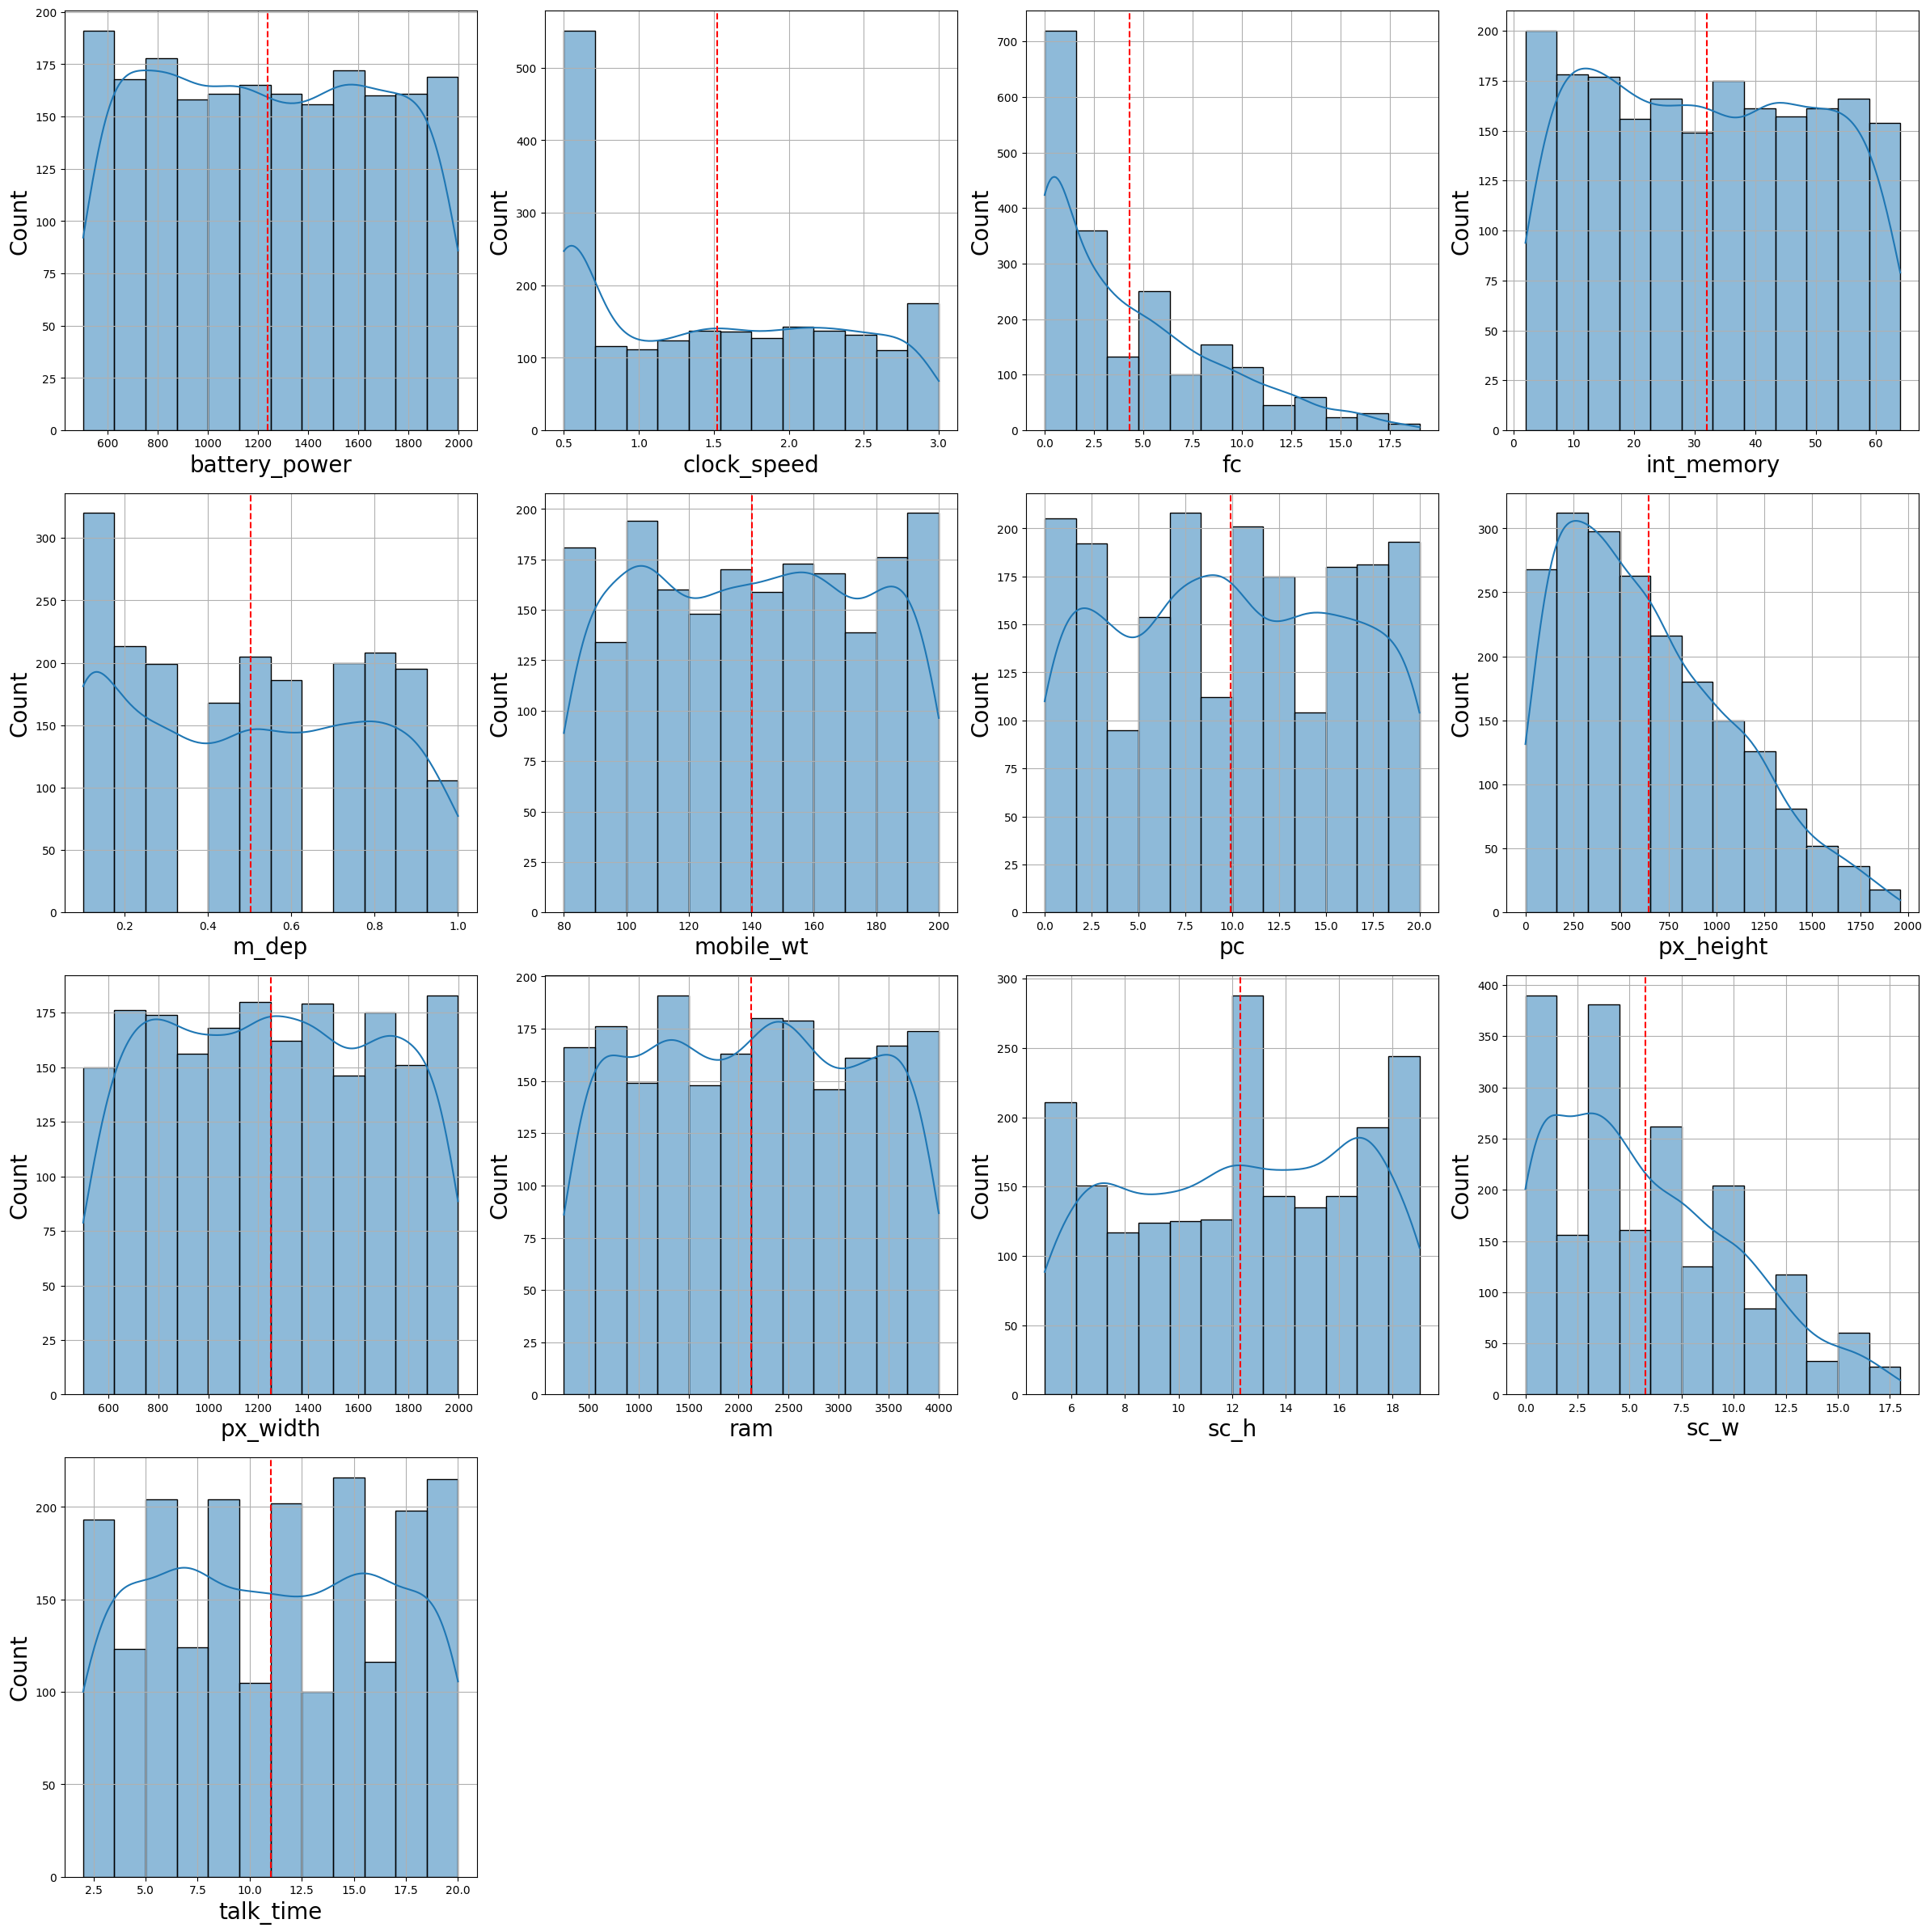

In [ ]:
fig, ax = plt.subplots(4, 4, figsize = (24, 24))

for i, col_name in enumerate(num_data.columns):
    row = i // 4
    col = i % 4

    sns.histplot(num_data[col_name], ax = ax[row, col], kde = True, bins = 'sturges')
    ax[row, col].axvline(num_data[col_name].mean(), color = 'red', linestyle = '--')

    ax[row, col].set_xlabel(col_name, fontsize = 20)
    ax[row, col].set_ylabel('Count', fontsize = 20)
    ax[row, col].grid()

ax[3, 1].axis('off')
ax[3, 2].axis('off')
ax[3, 3].axis('off')

plt.tight_layout()
plt.show()

m_dep, px_height, sc_w are left-skewed, closer to 0. Given that we have previously seen that these same features have an illogical minimum, it is necessary to check them in more detail

# Feature Engineering

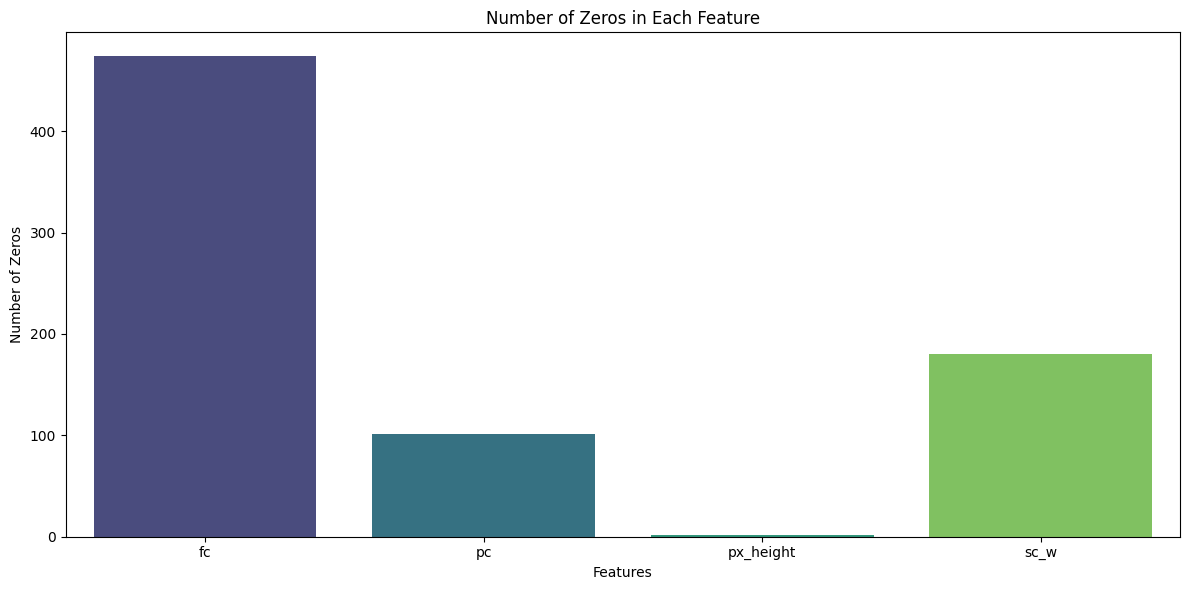

In [ ]:
zero_counts = (num_data == 0).sum()

zero_counts_nonzero = zero_counts[zero_counts != 0]

plt.figure(figsize = (12, 6))
sns.barplot(x = zero_counts_nonzero.index, y = zero_counts_nonzero.values, palette = 'viridis')

plt.xlabel('Features')
plt.ylabel('Number of Zeros')
plt.title('Number of Zeros in Each Feature')

plt.tight_layout()
plt.show()

**The fact that fc and pc are equal to 0 is a logical fact, because there are phones that do not have a front or even a main camera, so we can not pay much attention to it.**

I considered that minimum of the px_height is 65 pixels, sc_w is 2.54 inches, m_dep is 0.5 cm. This information I received from open sources about mobile phones.

In [ ]:
imputer = KNNImputer(n_neighbors=2)

In [ ]:
df_denoised = df.copy()

In [ ]:
below_mdep_threshold = df[df["m_dep"] < 0.5]["m_dep"]

print("The number of detected noise values for 'm_dep' feature: ", len(below_mdep_threshold))

df_denoised[df_denoised["m_dep"] < 0.5]["m_dep"] = np.nan

imputed_data = imputer.fit_transform(df_denoised)

df_denoised = pd.DataFrame(imputed_data, columns = df_denoised.columns)

The number of detected noise values for 'm_dep' feature:  900


In [ ]:
below_pxh_threshold = df["px_height"][df["px_height"] < 65]

print("The number of detected noise values for 'px_height' feature: ", len(below_pxh_threshold))

df_denoised[df_denoised["px_height"] < 65]["px_height"] = np.nan

imputed_data = imputer.fit_transform(df_denoised)

df_denoised = pd.DataFrame(imputed_data, columns = df_denoised.columns)

The number of detected noise values for 'px_height' feature:  90


In [ ]:
below_scw_threshold = df["sc_w"][df["sc_w"] < 2.54]

print("The number of detected noise values for 'sc_w' feature: ", len(below_scw_threshold))

df_denoised[df_denoised["sc_w"] < 2.54]["sc_w"] = np.nan

imputed_data = imputer.fit_transform(df_denoised)

df_denoised = pd.DataFrame(imputed_data, columns = df_denoised.columns)

The number of detected noise values for 'sc_w' feature:  546


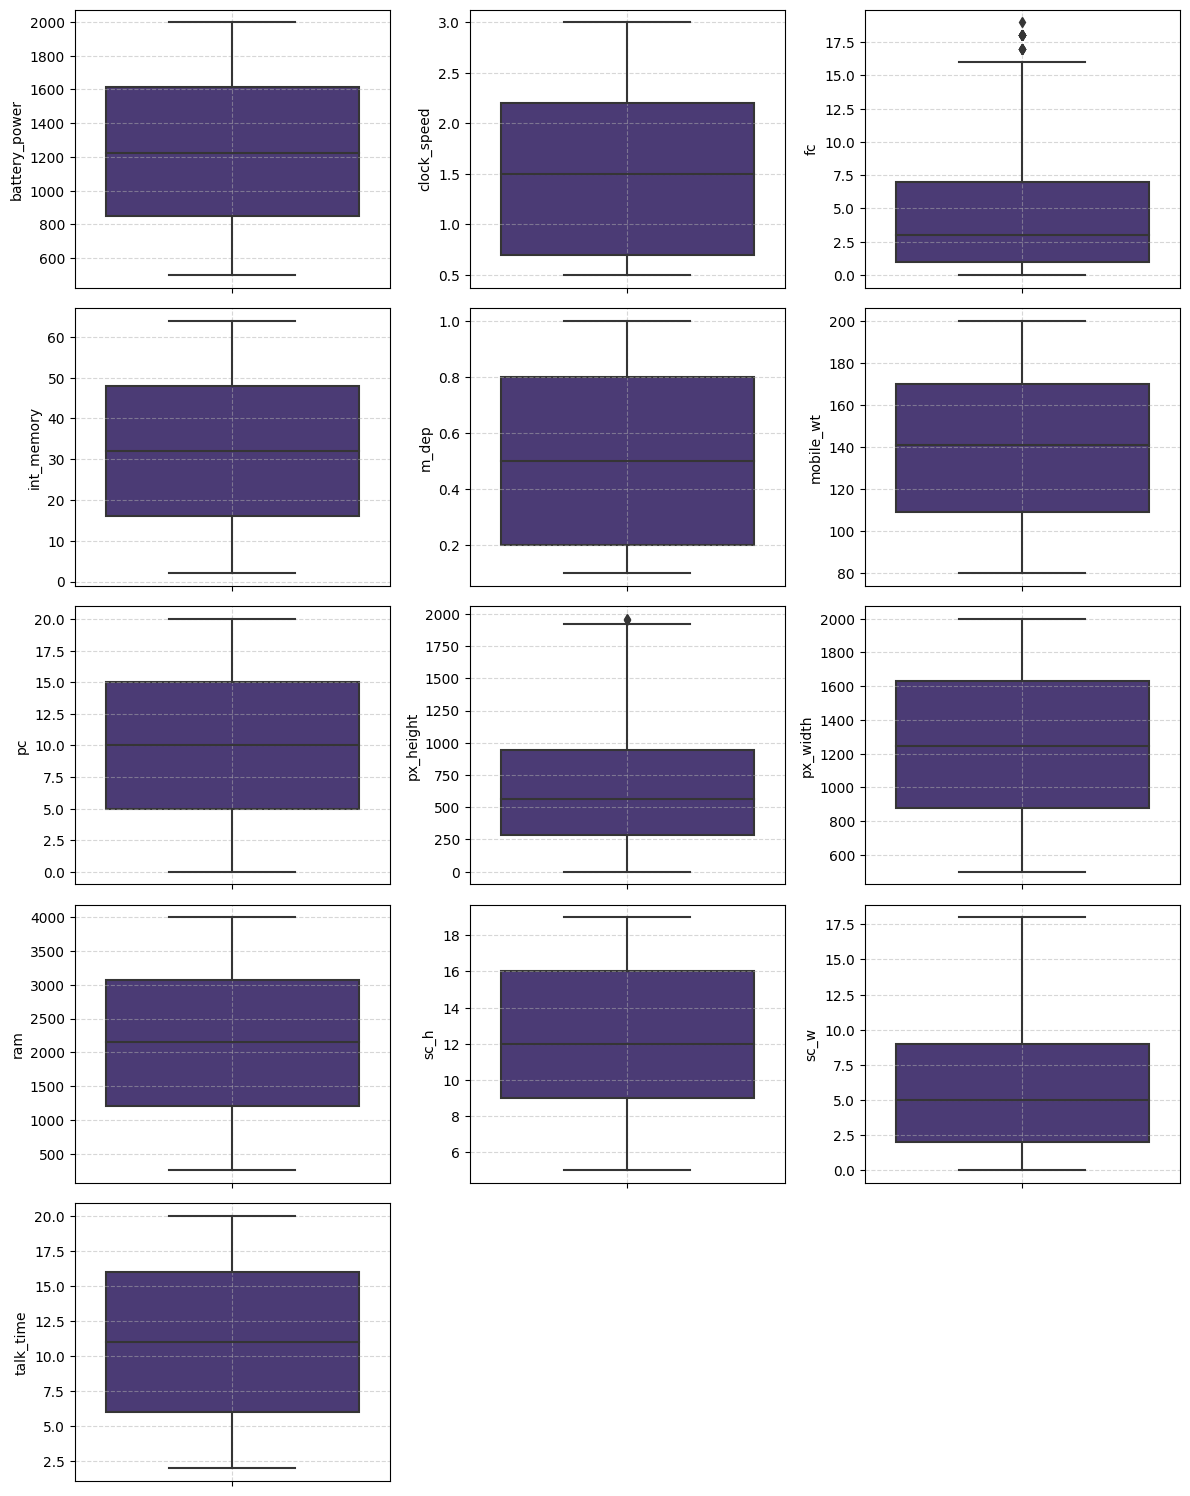

In [ ]:
plt.figure(figsize = (12, 18))
sns.set_palette("viridis")

for i, col_name in enumerate(num_data.columns):
    plt.subplot(6, 3, i + 1)
    sns.boxplot(y = df_denoised[col_name])
    plt.grid(True, linestyle="--", alpha = 0.5)


plt.tight_layout()
plt.show()

We have almost no outliers in the data, only in one of the categories, but this data (>1900) looks quite logical, so we will leave it

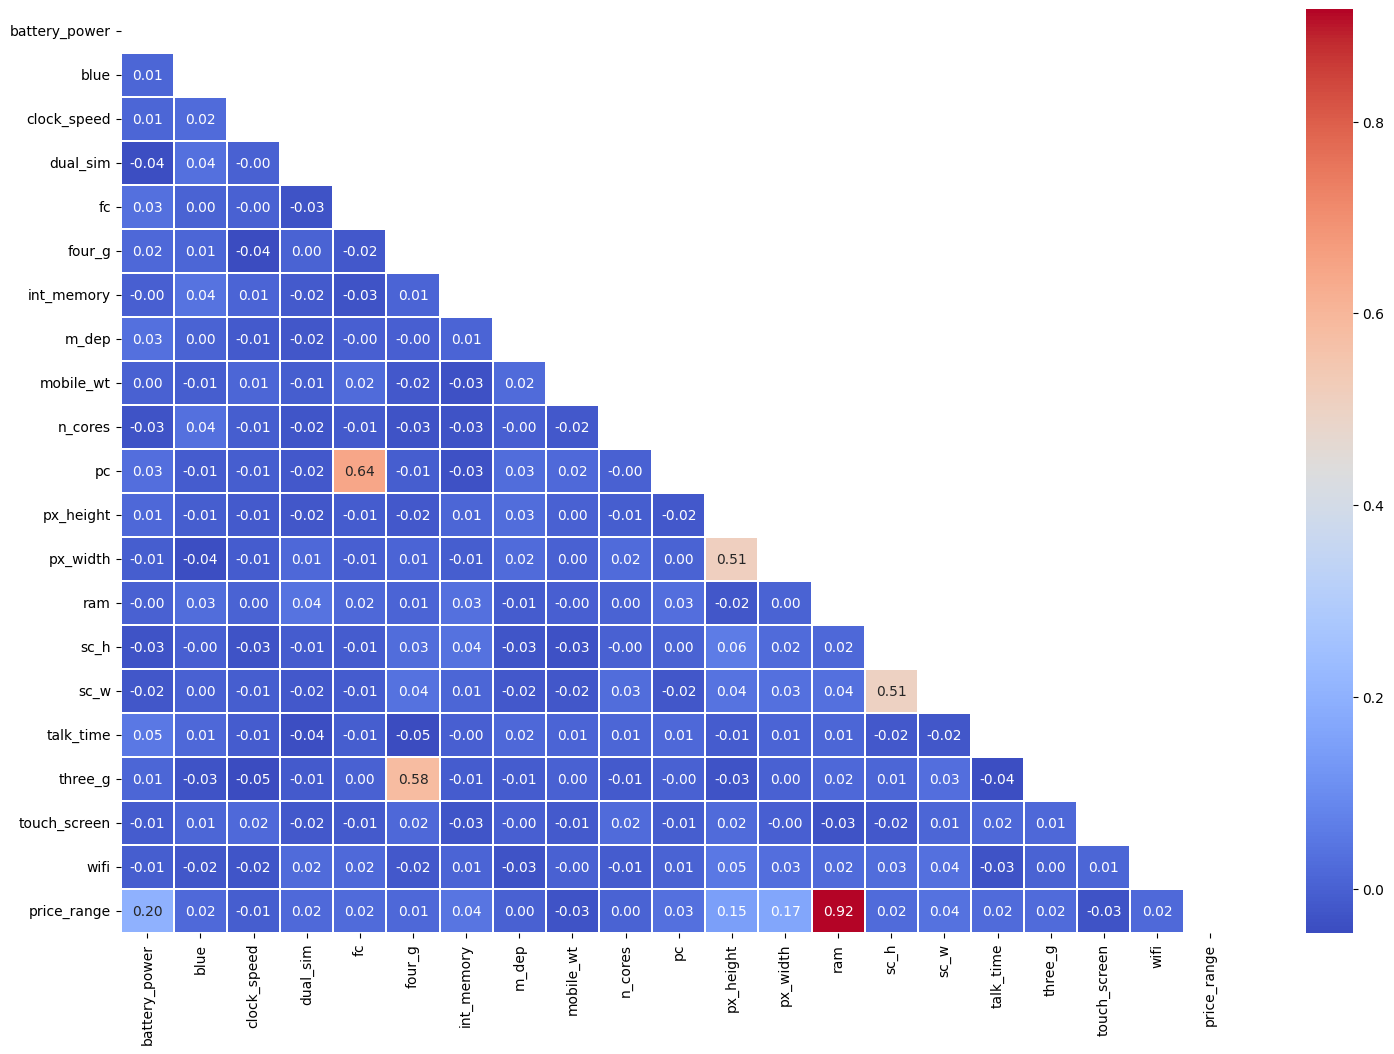

In [ ]:
# Calculation of the Spearman correlation
df_ordered = pd.concat([df_denoised.drop('price_range', axis = 1), df_denoised['price_range']], axis = 1)
corr = df_ordered.corr()

mask = np.triu(np.ones_like(corr))

plt.figure(figsize = (18,12))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', mask = mask, fmt = '.2f', linewidths = 0.2)
plt.show()

Only 4 features are significantly correlated with the result, all others have almost no effect

In [ ]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func = chi2, k = 10)
fit = bestfeatures.fit(df_denoised.drop('price_range', axis = 1), df_denoised['price_range'])

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_denoised.drop('price_range', axis = 1).columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs','Score']

print(featureScores.nlargest(10,'Score'))

            Specs          Score
13            ram  931267.519053
11      px_height   17363.569536
0   battery_power   14129.866576
12       px_width    9810.586750
8       mobile_wt      95.972863
6      int_memory      89.839124
15           sc_w      16.480319
16      talk_time      13.236400
4              fc      10.135166
14           sc_h       9.614878


Now we can leave only the first 4 features, and remove the others, because they almost do not affect the original result in many parameters. Let's finally check it with feature importance.

# Modeling

In [ ]:
X = df_denoised.drop('price_range', axis = 1)
y = df_denoised['price_range']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED, stratify = y)

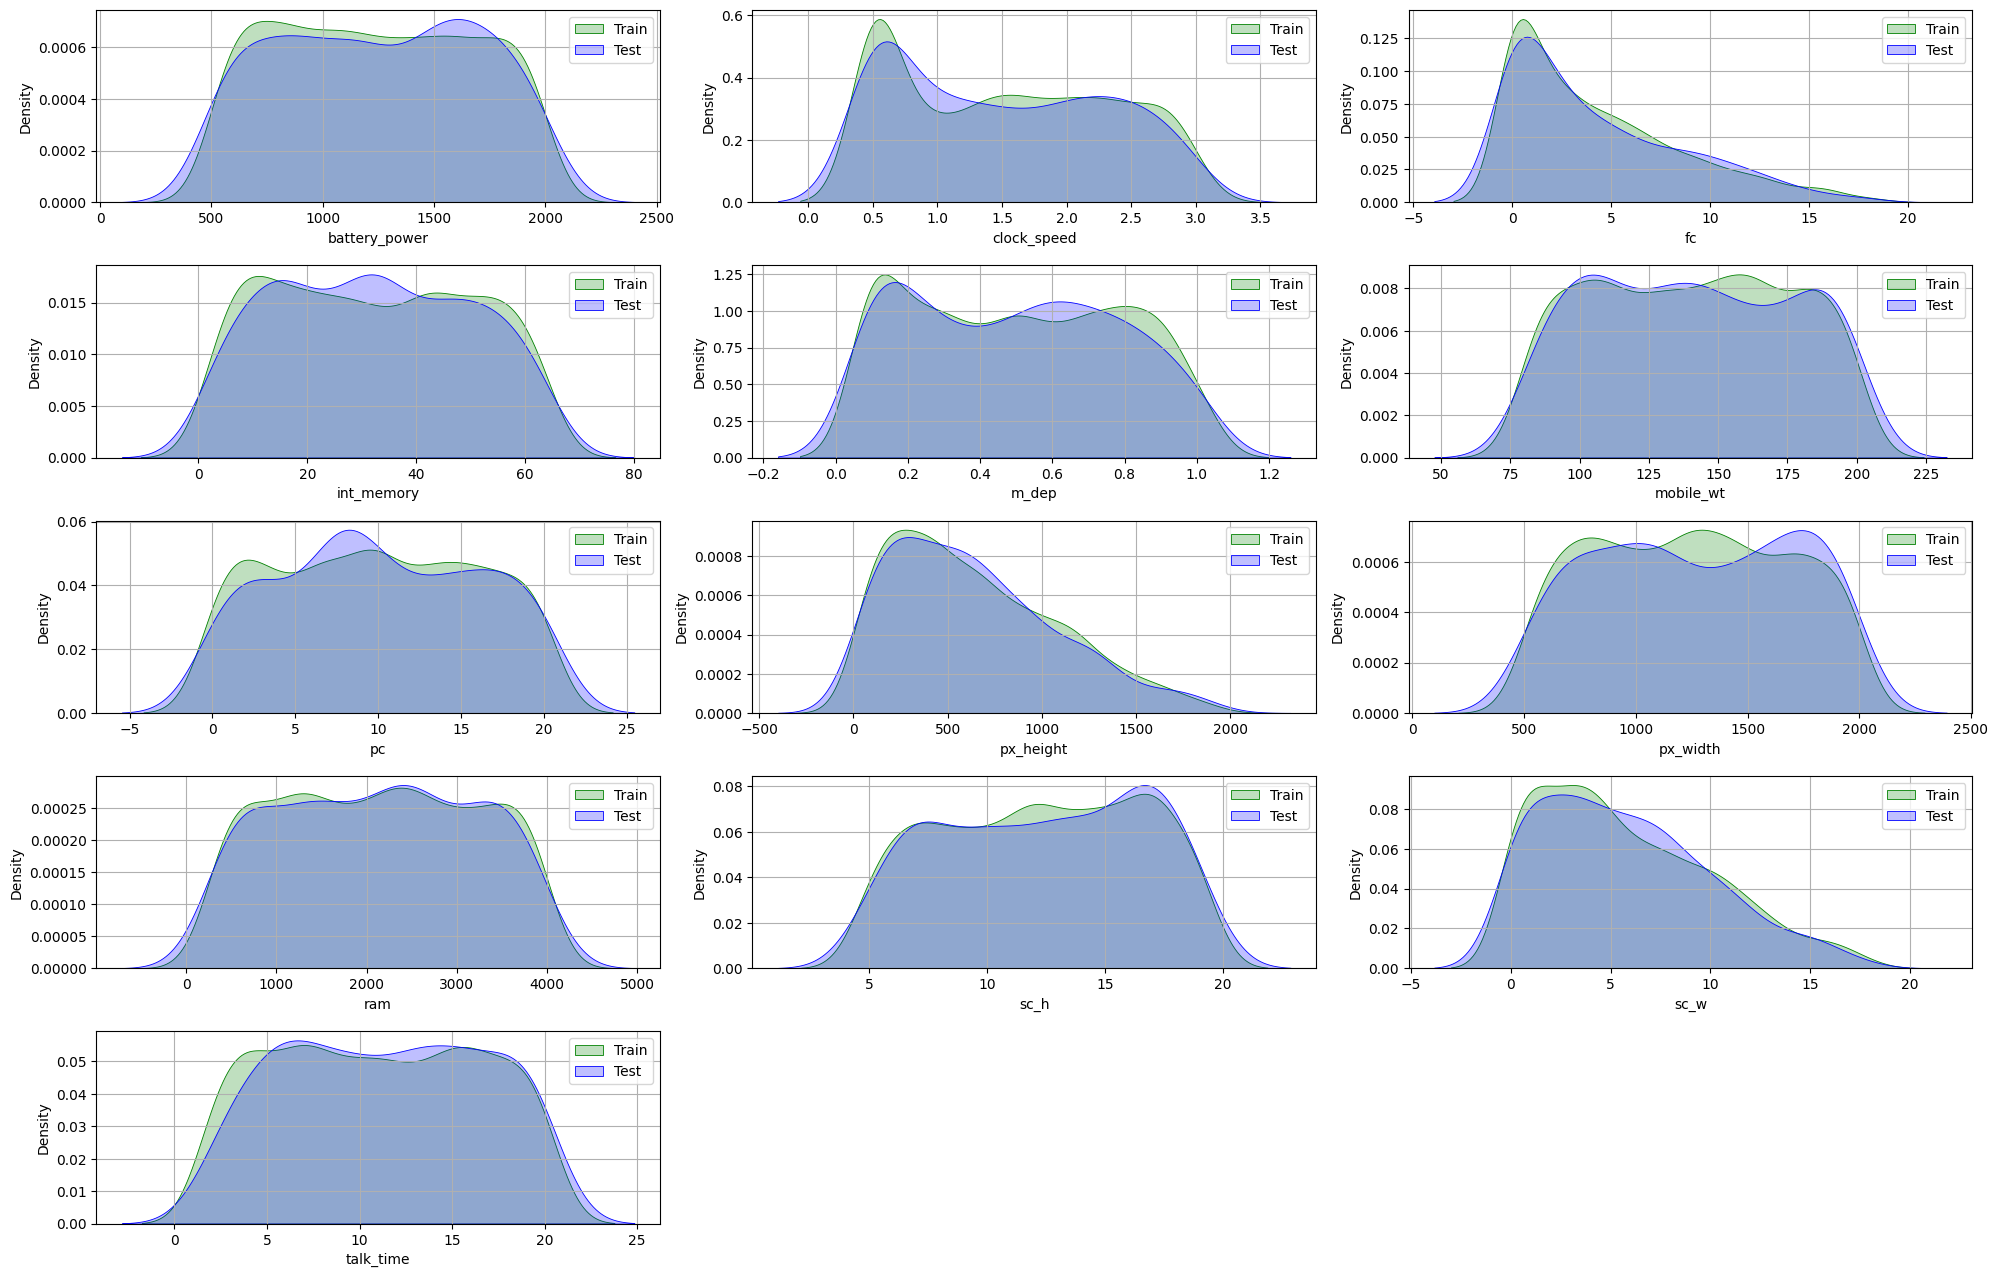

In [ ]:
fig = plt.figure(figsize = (20, 15))

for idx, num in enumerate(num_data.columns):
    ax = fig.add_subplot(6, 3, idx + 1)
    sns.kdeplot(x = num, fill = True,color = 'green', linewidth = 0.6, data = X_train, label = "Train")
    sns.kdeplot(x = num, fill = True, color = 'blue', linewidth = 0.6, data = X_test, label = "Test")
    ax.set_xlabel(num)
    ax.grid()
    ax.legend()
fig.tight_layout()
fig.show()

We have no problems dividing the data into test and training datasets, they have a fairly uniform distribution

In [ ]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)

Many machine learning models perform much better with data that is normalized

In [ ]:
def metrics(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    result = pd.DataFrame(data = [accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average = 'macro'),
                                recall_score(y_test, y_pred, average = 'macro'),
                                f1_score(y_test, y_pred, average = 'macro')],
                          index = ['Accuracy', 'Precision', 'Recall', 'Macro F1-score'],
                          columns = [model_name])

    result = (result * 100).round(3).astype(str) + '%'
    return result

def evaluation_print(model, X_train, X_test, y_train, y_test, model_name):
    print("\n# Classification Report for Training Set")
    print("-" * 50)
    print(classification_report(y_train, model.predict(X_train)))

    print("\n# Classification Report for Validation Set")
    print("-" * 50)
    print(classification_report(y_test, model.predict(X_test)))

    fig, (ax1, ax2) = plt.subplots(1, 2, dpi = 120, figsize = (12, 5))

    result = metrics(model, X_test, y_test, model_name)
    table = ax1.table(cellText = result.values, colLabels = result.columns, rowLabels = result.index, loc = 'center', cellLoc="left", colLoc="left")
    table.scale(0.6, 4.2)
    table.set_fontsize(9)
    ax1.axis('tight')
    ax1.axis('off')
    ax1.set_title('{} - Performance summary on test set'.format(model_name))

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, colorbar = False, ax = ax2)
    ax2.set_title('Confusion matrix for test data')
    ax2.grid(False)

    plt.tight_layout()
    plt.show()


As mentioned above, because our dataset is balanced on the target variable, we can use the accuracy metric. But also in order to understand how comprehensive and accurate our solution is, we use precision, recall and f1-score. Precision helps us understand the proportion of correctly identified positive instances among all instances predicted as positive, which is crucial when false positives are costly. Recall shows the model's ability to capture all actual positive instances, addressing scenarios where false negatives are particularly undesirable. The F1-score, being a harmonic mean of precision and recall, provides a balanced measure that considers both false positives and false negatives.

By utilizing this combination of metrics, we aim to not only gauge the overall accuracy of our model but also to assess its performance with respect to specific aspects of interest.

In [ ]:
def tune_hyperparameters(model, param_grid, X_train, y_train):

    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)

    model_grid = GridSearchCV(model, param_grid, cv = cv, scoring = 'accuracy', n_jobs = -1)

    # Fit the GridSearchCV object to the training data
    model_grid.fit(X_train, y_train)

    print("Best hyperparameters:\n", model_grid.best_params_)

    return model_grid.best_estimator_

**It is worth noting that even though our dataset is quite clean, without outliers and imbalance, it is small, and therefore we cannot use, for example, neural networks, since they will not be able to learn effectively on such a small amount of data. The following three methods were chosen: SVM, Random Forest and XGBoost. They work great and efficiently with a small amount of data, but it's worth considering the specifics of each.**

## SVC

I chose this method because it works well in high-dimensional spaces and can handle non-linear relationships using kernel trick. Also it works well for small datasets and it has sensitivity to noise and outliers, so we should clean them.

The search for optimal hyperparameters takes a long time, so I left only a part of them in the work

In [ ]:
param_grid = {'kernel': ['linear', 'poly'],
               'C': [0.001, 0.01, 0.1, 60, 70, 80, 90],
               'degree': [2, 3]
             }

In [ ]:
svm_o = SVC(probability = True, random_state = SEED)

# Find the best classifier with the optimal hyperparameters
svm_optimized = tune_hyperparameters(svm_o, param_grid, X_train, y_train)

Best hyperparameters:
 {'C': 70, 'degree': 2, 'kernel': 'linear'}



# Classification Report for Training Set
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       400
         1.0       0.98      0.97      0.98       400
         2.0       0.97      0.98      0.98       400
         3.0       0.99      0.99      0.99       400

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600


# Classification Report for Validation Set
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       100
         1.0       0.98      0.97      0.97       100
         2.0       0.97      0.96      0.96       100
         3.0       0.98      0.99      0.99       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       4

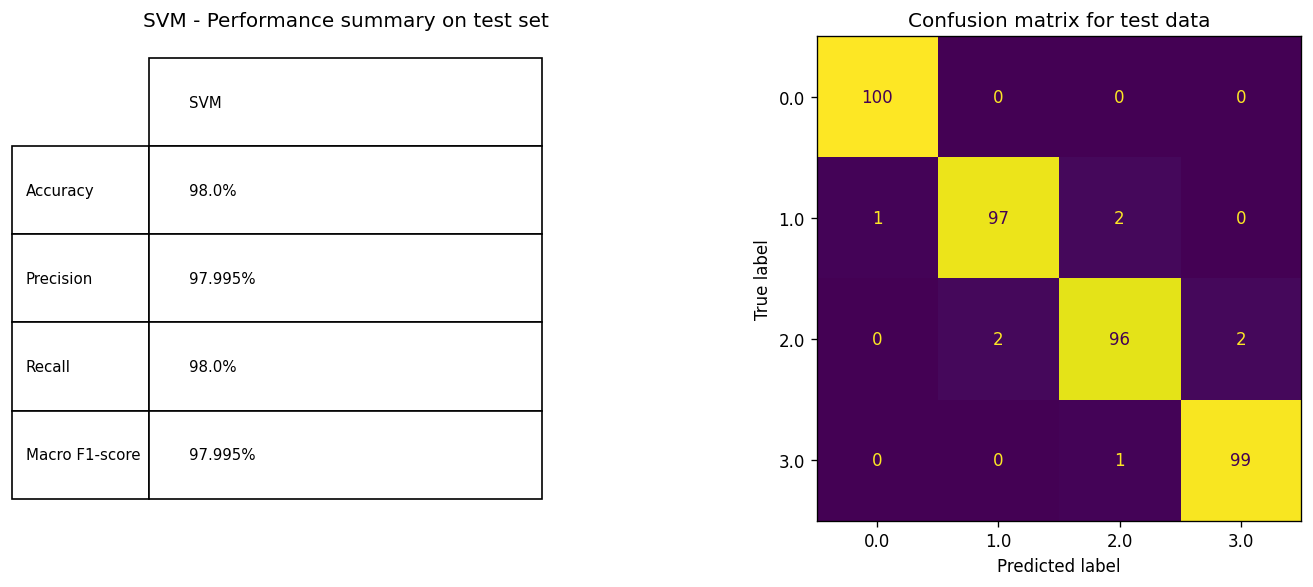

In [ ]:
evaluation_print(svm_optimized, X_train, X_test, y_train, y_test, 'SVM')

Let's try to test our model on trimmed data

In [ ]:
selected_features = ['ram', 'battery_power', 'px_height', 'px_width']

X_train_f = X_train[selected_features]
X_test_f = X_test[selected_features]

In [ ]:
svm_f = SVC(probability = True, random_state = SEED)

# Find the best classifier with the optimal hyperparameters
svm_feature = tune_hyperparameters(svm_f, param_grid, X_train_f, y_train)

Best hyperparameters:
 {'C': 90, 'degree': 2, 'kernel': 'linear'}



# Classification Report for Training Set
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       400
         1.0       0.94      0.97      0.96       400
         2.0       0.95      0.94      0.94       400
         3.0       0.97      0.96      0.97       400

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600


# Classification Report for Validation Set
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       100
         1.0       0.97      0.97      0.97       100
         2.0       0.95      0.93      0.94       100
         3.0       0.96      0.97      0.97       100

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       4

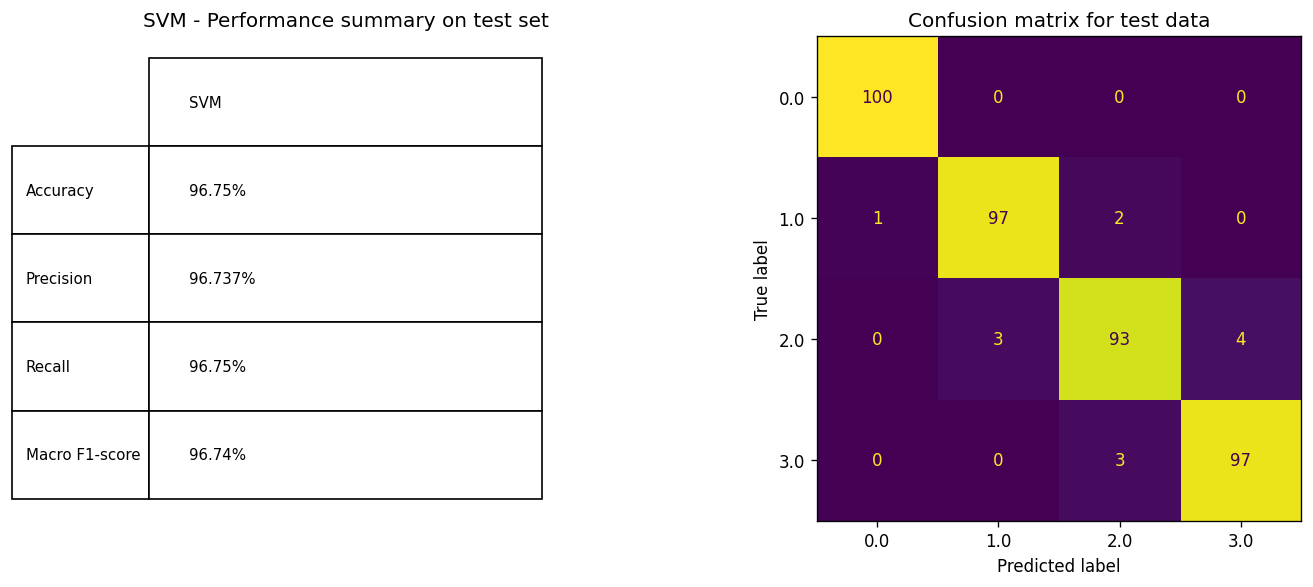

In [ ]:
evaluation_print(svm_feature, X_train_f, X_test_f, y_train, y_test, 'SVM')

As we can see, SVM works better with full data, even before the removal of irrelevant features, this can be explained by the fact that this method works well in high-dimensional spaces and on a small volume of data it uses all possible ways of dividing the data by a hyperplane, using less relevant features

In [ ]:
svm_result = metrics(svm_optimized, X_test, y_test, 'SVM')

## Random Forest

I chose this method because it can handle a mixture of numerical and categorical features and resistant to overfitting, also it works well in small datasets.

In [ ]:
param_grid = {
      'n_estimators': [50, 100, 150],
      'max_depth': [5, 10, 12, 15],
      'min_samples_split': [2, 4, 8],
      'min_samples_leaf': [1, 2, 4],
}


rf = RandomForestClassifier(criterion = 'gini', max_features = None, bootstrap = True, random_state = SEED)

rf_optimised = tune_hyperparameters(rf, param_grid, X_train, y_train)

Best hyperparameters:
 {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


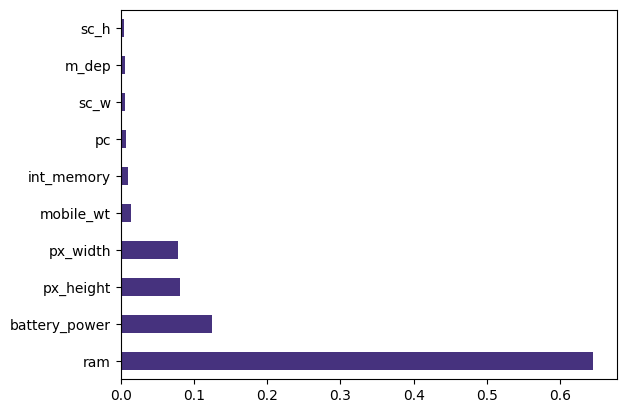

In [ ]:
feat_importances = pd.Series(rf_optimised.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

In [ ]:
X_train_f = X_train[selected_features]
X_test_f = X_test[selected_features]

In [ ]:
rf = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

rf_optimised = tune_hyperparameters(rf, param_grid, X_train_f, y_train)

Best hyperparameters:
 {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}



# Classification Report for Training Set
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       400
         1.0       1.00      1.00      1.00       400
         2.0       1.00      1.00      1.00       400
         3.0       1.00      1.00      1.00       400

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600


# Classification Report for Validation Set
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       100
         1.0       0.90      0.90      0.90       100
         2.0       0.89      0.88      0.88       100
         3.0       0.96      0.94      0.95       100

    accuracy                           0.93       400
   macro avg       0.92      0.92      0.92       4

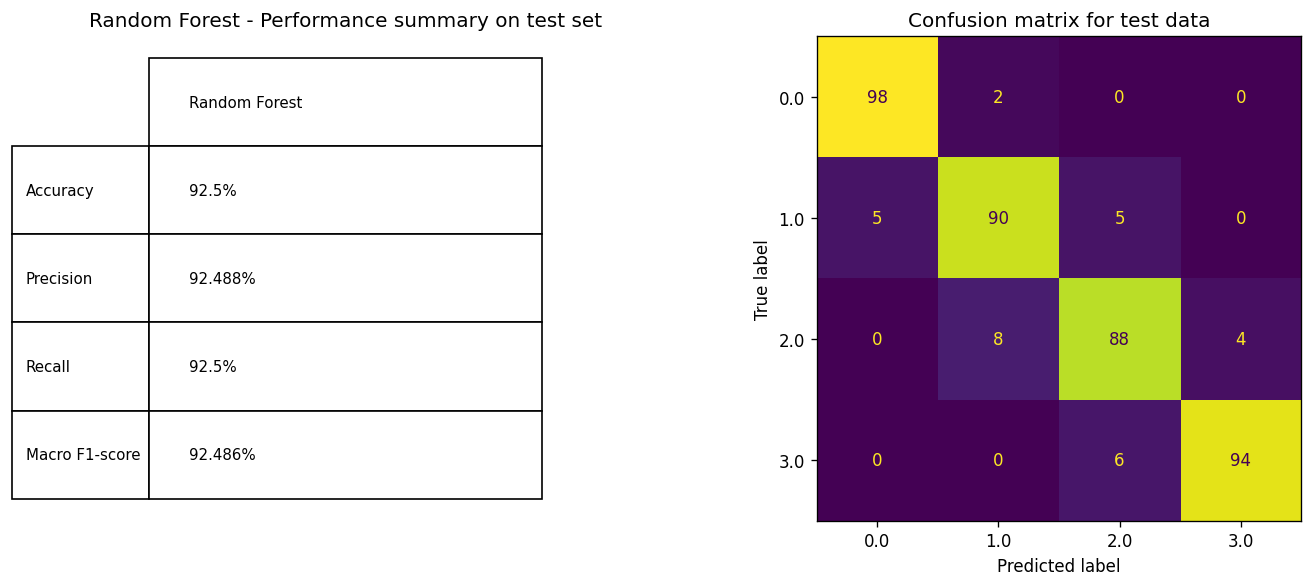

In [ ]:
evaluation_print(rf_optimised, X_train_f, X_test_f, y_train, y_test, 'Random Forest')

In [ ]:
rf_result = metrics(rf_optimised, X_test_f, y_test, 'Random Forest')

## XGBoost

Handles missing data well. Robust to outliers.

In [ ]:
param_grid = {
    'learning_rate': [0.1, 0.175, 0.25],
    'n_estimators': [150, 170, 190],
    'max_depth': [2, 4, 6],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.1, 0.3]
}

xgb_classifier = xgb.XGBClassifier()

xgb_optimized = tune_hyperparameters(xgb_classifier, param_grid, X_train_f, y_train)

Best hyperparameters:
 {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 170}



# Classification Report for Training Set
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       400
         1.0       1.00      1.00      1.00       400
         2.0       1.00      1.00      1.00       400
         3.0       1.00      1.00      1.00       400

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600


# Classification Report for Validation Set
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       100
         1.0       0.95      0.93      0.94       100
         2.0       0.91      0.92      0.92       100
         3.0       0.97      0.95      0.96       100

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       4

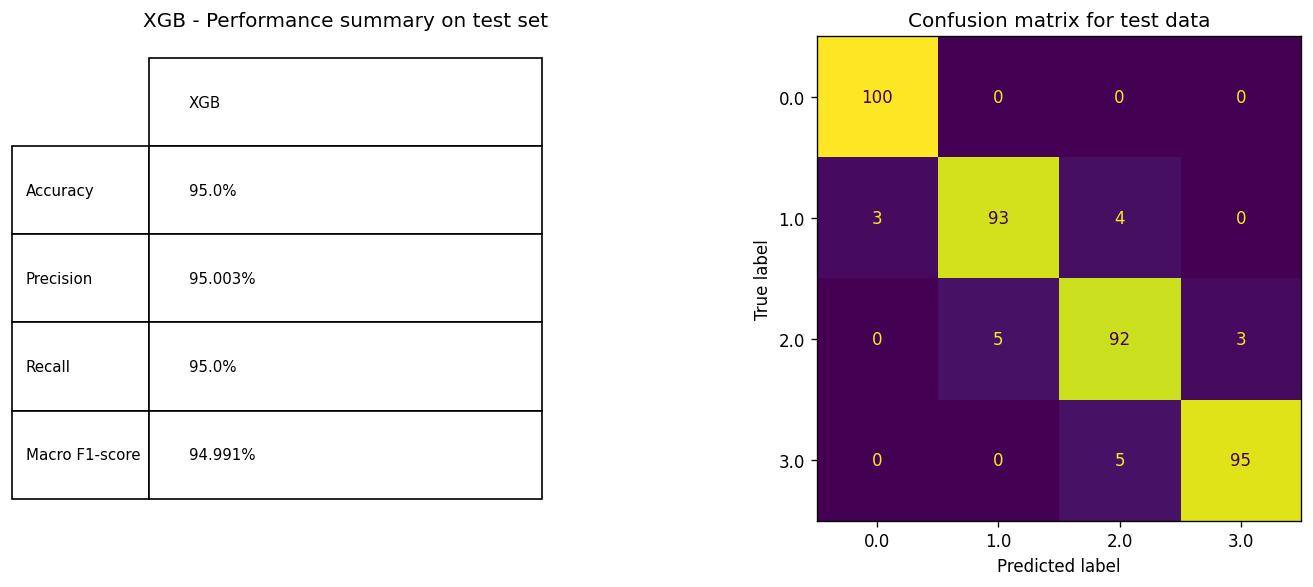

In [ ]:
evaluation_print(xgb_optimized, X_train_f, X_test_f, y_train, y_test, 'XGB')

In [ ]:
xgb_result = metrics(xgb_optimized, X_test_f, y_test, 'XGB')

# Conclusions

In [ ]:
results = pd.concat([svm_result, rf_result, xgb_result], axis = 1).T
results.sort_values(by = 'Accuracy', ascending = False, inplace = True)

results

Accuracy Precision Recall Macro F1-score
SVM              98.0%   97.995%  98.0%        97.995%
XGB              95.0%   95.003%  95.0%        94.991%
Random Forest    92.5%   92.488%  92.5%        92.486%

So we can draw the following conclusions: 1) RAM size is the key to success, if it increases, the price increases 2) Battery capacity does the same 3) The larger the display, the higher the price

SVC is the best, which is quite expected, because with the right selection of hyperparameters, it works well for a small amount of data, and given that there were almost no outliers in the data, it works stably. XGBoost also showed a good result, although it may make sense to try to adjust its hyperparameters or clean the data correctly for it. Random forest is not the best option because it often suffers from overtraining